# Important Library Imports

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import math
from torchvision.utils import make_grid
import time

# Helper Functions

In [7]:
def validate_model(model, val_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in val_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

def test_model(model, test_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in test_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

# def visualize_filters(tensor, title="Filters", num=8):
#     tensor = tensor.cpu().detach()
#     fig, axs = plt.subplots(1, num, figsize=(num * 2, 2))
#     for i in range(num):
#         axs[i].imshow(tensor[i, 0, :, :], cmap='viridis')  # Show first channel of each filter
#         axs[i].axis('off')
#     fig.suptitle(title)
#     plt.show()

# Set up Data Augmentation and Load Data

In [8]:
# data_transforms = transforms.Compose([
#     transforms.RandomChoice([
#         transforms.RandomApply([
#             transforms.RandomHorizontalFlip(p=1.0)
#         ], p=0.4),
#         transforms.RandomApply([
#             transforms.RandomVerticalFlip(p=1.0)
#         ], p=0.4),
#     ]),
#     transforms.ToTensor()
# ])

data_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomApply([
            transforms.ElasticTransform(alpha=40.0, sigma=8.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, shear=20, fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(p=1.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomVerticalFlip(p=1.0)
        ], p=0.2),
    ]),
    transforms.ToTensor()
])

In [9]:
LABELS = ["Apple Scab", "Apple Black Rot", "Apple Cedar Rust", "Apple Healthy", "Blueberry Healthy", "Cherry Healthy", "Cherry Powdery Mildew", "Corn Cercospora Leaf Spot", "Corn Common Rust", "Corn Healthy", "Corn Northern Leaf Blight", "Grape Black Rot", "Grape Black Measles", "Grape Healthy", "Grape Isariopsis Leaf Spot", "Orange Haunglonbing",
          "Peach Bacterial Spot", "Peach Healthy", "Bell Pepper Bacterial Spot", "Bell Pepper Healthy", "Potato Early Blight", "Potato Healthy", "Potato Late Blight", "Raspberry Healthy", "Soybean Healthy", "Squash Powdery Mildew", "Strawberry Healthy", "Strawberry Leaf Scorch", "Tomato Bacterial Spot", "Tomato Early Blight", "Tomato Healthy",
          "Tomato Late Blight", "Tomato Leaf Mold", "Tomato Septoria Leaf Spot", "Tomato Spider Mites", "Tomato Target Spot", "Tomato Mosaic Virus", "Tomato Yellow Leaf Curl Virus"]

BATCH_SIZE = 128
DEVICE = torch.device("cuda")
folder_path = "PlantVillage"

train_set = ImageFolder(root=folder_path + "\Training", transform=data_transforms)
val_set = ImageFolder(root=folder_path + "\Validation", transform=transforms.ToTensor())
test_set = ImageFolder(root=folder_path + "\Testing", transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Model Construction

In [10]:
class DiseasedCNN(nn.Module):
    def __init__(self):
        super().__init__()

        resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device=DEVICE)
        self.backbone = nn.Sequential(*list(resnet50.children())[:-2]).to(device=DEVICE) # Get everything up to the avg pooling layer
        # Freeze the base
        for param in resnet50.parameters():
            param.requires_grad = False

        conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1).to(device=DEVICE)
        relu1 = nn.ReLU().to(device=DEVICE)

        conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1).to(device=DEVICE)
        batchnorm = nn.BatchNorm2d(256).to(device=DEVICE)
        relu2 = nn.ReLU().to(device=DEVICE)

        pool = nn.AdaptiveAvgPool2d((1, 1)).to(DEVICE)
        flatten = nn.Flatten().to(DEVICE)

        fcn1 = nn.Linear(256, 64).to(device=DEVICE)
        relu3 = nn.ReLU().to(device=DEVICE)

        fcn2 = nn.Linear(64, 38).to(device=DEVICE)
        softmax = nn.Softmax().to(DEVICE)

        self.layers = nn.Sequential(conv1, relu1, conv2, batchnorm, relu2, pool, flatten, fcn1, relu3, fcn2, softmax).to(DEVICE)

        # print(self.backbone)
        # print()
        # print()
        # print(self.layers)

    def forward(self, x):
        x = self.backbone(x).to(DEVICE)
        return self.layers(x).to(DEVICE)

# Train Model

### Perform Training

In [11]:
CONTINUE_TRAINING = True

NUM_EPOCHS = 16
learning_rate = 0.0001
adam_beta1 = 0.9
adam_beta2 = 0.999

model = DiseasedCNN()

model.train()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2))
criterion = nn.CrossEntropyLoss()

start_epoch = 0

# For picking up training later
if CONTINUE_TRAINING:
    checkpoint = torch.load("model_74_optimizer_state.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    model.train()
# For picking up training later
# PUT SOMETHING IN TO TIME EACH EPOCH
epoch_loss = []
train_loss = []
validaction_acc = []

for epoch in range(start_epoch, NUM_EPOCHS):
    print("Epoch: %d" % epoch)
    for step_num, (batch, labels) in enumerate(train_loader):
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(batch)

        optimizer.zero_grad()
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()

        if (step_num + 1) % 13 == 0:
            print("Batch %d" % step_num)
            # Perform validation and store accuracy
            validation_accuracy = validate_model(model=model, val_loader=val_loader, device=DEVICE)
            validaction_acc.append(validation_accuracy)

        train_loss.append(loss.item())


    # Track average loss for each epoch
    epoch_loss.append(sum(train_loss) / len(train_loss))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\smitd/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100.0%


Epoch: 10


C:\Users\smitd\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batch 12
Batch 25
Batch 38
Batch 51
Batch 64
Batch 77
Batch 90
Batch 103
Batch 116
Batch 129
Batch 142
Batch 155
Batch 168
Batch 181
Batch 194
Batch 207
Batch 220
Batch 233
Batch 246
Batch 259
Batch 272
Batch 285
Batch 298
Batch 311
Batch 324
Batch 337
Epoch: 11
Batch 12
Batch 25
Batch 38
Batch 51
Batch 64
Batch 77
Batch 90
Batch 103
Batch 116
Batch 129
Batch 142
Batch 155
Batch 168
Batch 181
Batch 194
Batch 207
Batch 220
Batch 233
Batch 246
Batch 259
Batch 272
Batch 285
Batch 298
Batch 311
Batch 324
Batch 337
Epoch: 12
Batch 12
Batch 25
Batch 38
Batch 51
Batch 64
Batch 77
Batch 90
Batch 103
Batch 116
Batch 129
Batch 142
Batch 155
Batch 168
Batch 181
Batch 194
Batch 207
Batch 220
Batch 233
Batch 246
Batch 259
Batch 272
Batch 285
Batch 298
Batch 311
Batch 324
Batch 337
Epoch: 13
Batch 12
Batch 25
Batch 38
Batch 51
Batch 64
Batch 77
Batch 90
Batch 103
Batch 116
Batch 129
Batch 142
Batch 155
Batch 168
Batch 181
Batch 194
Batch 207
Batch 220
Batch 233
Batch 246
Batch 259
Batch 272
Batch 28

### Plot Loss

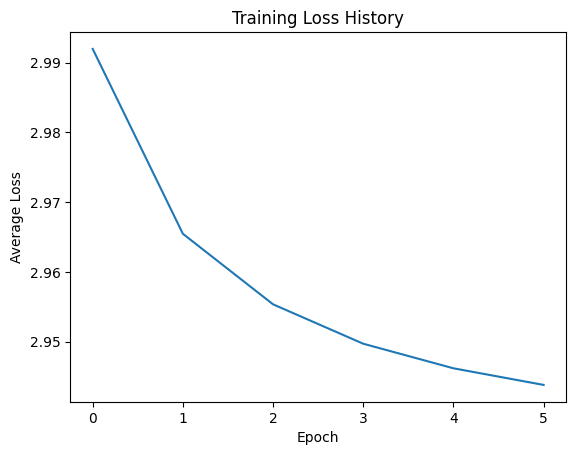

In [12]:
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.plot(epoch_loss)
plt.show()

### Plot Validation Accuracy

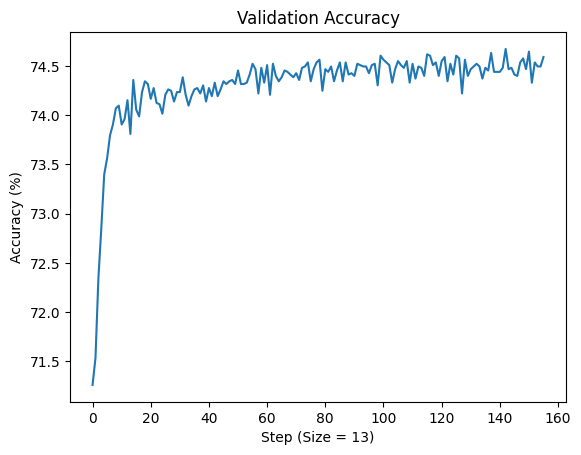

In [13]:
plt.title("Validation Accuracy")
plt.xlabel("Step (Size = 13)")
plt.ylabel("Accuracy (%)")
plt.plot(validaction_acc)
plt.show()

### Visualize Weights

In [ ]:
# THIS NEEDS TO BE TESTED

bottleneck = model.backbone[-1][1]
conv = bottleneck.conv1
filters = conv.weights

nrow = math.ceil(math.sqrt(filters.shape[0]))
grid = make_grid(filters, nrow=nrow, padding=1, normalize=True, scale_each=True)
plt.imshow(grid.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Test Model

In [15]:
accuracy = test_model(model=model, test_loader=test_loader, device=DEVICE)
print("Model accuracy: %f" % accuracy)

Model accuracy: 74.747758


In [16]:
torch.save(model.state_dict(), "extension_model_74.pth")

In [17]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "model_74_optimizer_state.pth")